##Resnet- implementation 

In [19]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
import numpy as np

##Resnet

In [20]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

In [22]:
class Block(nn.Module):
    def __init__(self, input_channels, output_channels, stride=1, downsample=None):
        super(Block, self).__init__()
        self.conv1 = conv3x3(input_channels, output_channels, stride)
        self.bn1 = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(output_channels, output_channels)
        self.bn2 = nn.BatchNorm2d(output_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        output = self.conv1(x)
        output = self.bn1(output)
        output = self.relu(output)
        output = self.conv2(output)
        output = self.bn2(output)
        if self.downsample:
            residual = self.downsample(x)
        output += residual
        output = self.relu(output)
        return output

In [23]:
class Resnet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(Resnet, self).__init__()
        self.input_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, output_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.input_channels != output_channels):
           downsample = nn.Sequential(conv3x3(self.input_channels, output_channels, stride=stride),nn.BatchNorm2d(output_channels))
        layers = []
        layers.append(block(self.input_channels, output_channels, stride, downsample))
        self.input_channels = output_channels
        for i in range(1, blocks):
            layers.append(block(output_channels, output_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv(x)
        output = self.bn(output)
        output = self.relu(output)
        output = self.layer1(output)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)
        return output


###Data preprocessing

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
transform = transforms.Compose([transforms.Pad(4),transforms.RandomHorizontalFlip(),transforms.RandomCrop(32),transforms.ToTensor()])

In [26]:
train_dataset = torchvision.datasets.CIFAR10(root='../../data/', train=True, transform=transform,download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',train=False, transform=transforms.ToTensor())

Files already downloaded and verified


In [27]:
train_dataset, val_dataset= random_split(train_dataset,(45000,5000))

In [28]:
train_loader = DataLoader(dataset=train_dataset,batch_size=100, shuffle=True)
val_loader = DataLoader(dataset=val_dataset,batch_size=100, shuffle=True) 
test_loader = DataLoader(dataset=test_dataset,batch_size=100, shuffle=False)

In [29]:
epochs = 80
learning_rate = 0.001

In [30]:
print("image shape {}".format(train_dataset[0][0].numpy().shape))

image shape (3, 32, 32)


In [31]:
print("training data: {} images".format(len(train_dataset)))
print("validation data: {} images".format(len(val_dataset)))
print("test data: {} images".format(len(test_dataset)))

training data: 45000 images
validation data: 5000 images
test data: 10000 images


In [32]:
model = Resnet(Block, [2, 2, 2]).to(device)

In [33]:
summary(model,(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
            Block-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 16, 32, 32]           2,304
      BatchNorm2d-12           [-1, 16, 32, 32]              32
             ReLU-13           [-1, 16, 32, 32]               0
           Conv2d-14           [-1, 16,

###Training the model

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [35]:
def update_lr(optimizer, lr):    
    for param_grp in optimizer.param_groups:
        param_grp['lr'] = lr

In [38]:
total_step = len(train_loader)
current_lr = learning_rate
train_costs,val_costs=[],[]
train_acc,val_acc=[],[]
for epoch in range(epochs):
    train_correct=0
    train_running_loss=0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted==labels).float().sum().item()
        train_running_loss +=(loss.data.item()*images.shape[0])

     # Decay learning rate
    if (epoch+1) % 20 == 0:
        current_lr /= 3
        update_lr(optimizer, current_lr)
      

    train_epoch_loss= train_running_loss/len(train_dataset)
    train_costs.append(train_epoch_loss)
    train_accuracy=train_correct/len(train_dataset)
    train_acc.append(train_accuracy)

    val_correct=0
    val_running_loss=0
    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
          images = images.to(device)
          labels = labels.to(device)

        # Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)


          _, predicted = torch.max(outputs.data, 1)
          val_correct += (predicted==labels).float().sum().item()
          val_running_loss +=(loss.data.item()*images.shape[0])

   

        val_epoch_loss= val_running_loss/len(val_dataset)
        val_costs.append(val_epoch_loss)
        val_accuracy=val_correct/len(val_dataset)
        val_acc.append(val_accuracy)




    
    print ("Epoch [{}/{}],  train_epoch_Loss: {:.4f}, val_epoch_loss: {:.4f}, train_accuracy: {:.4f}, val_accuracy: {:.4f}".format(epoch+1, epochs, train_epoch_loss,val_epoch_loss,train_accuracy,val_accuracy ))

    

Epoch [1/80],  train_epoch_Loss: 1.4364, val_epoch_loss: 1.3179, train_accuracy: 0.4697, val_accuracy: 0.5226
Epoch [2/80],  train_epoch_Loss: 1.9526, val_epoch_loss: 1.7564, train_accuracy: 0.2521, val_accuracy: 0.3310
Epoch [3/80],  train_epoch_Loss: 1.6464, val_epoch_loss: 1.4229, train_accuracy: 0.3809, val_accuracy: 0.4700
Epoch [4/80],  train_epoch_Loss: 1.3954, val_epoch_loss: 1.2548, train_accuracy: 0.4824, val_accuracy: 0.5376
Epoch [5/80],  train_epoch_Loss: 1.2503, val_epoch_loss: 1.1097, train_accuracy: 0.5442, val_accuracy: 0.5982
Epoch [6/80],  train_epoch_Loss: 1.1425, val_epoch_loss: 1.0638, train_accuracy: 0.5873, val_accuracy: 0.6222
Epoch [7/80],  train_epoch_Loss: 1.0624, val_epoch_loss: 0.9560, train_accuracy: 0.6202, val_accuracy: 0.6518
Epoch [8/80],  train_epoch_Loss: 0.9981, val_epoch_loss: 1.0346, train_accuracy: 0.6463, val_accuracy: 0.6350
Epoch [9/80],  train_epoch_Loss: 0.9492, val_epoch_loss: 0.8854, train_accuracy: 0.6620, val_accuracy: 0.6852
Epoch [10/

In [39]:
torch.save(model.state_dict(), 'resnet.ckpt')

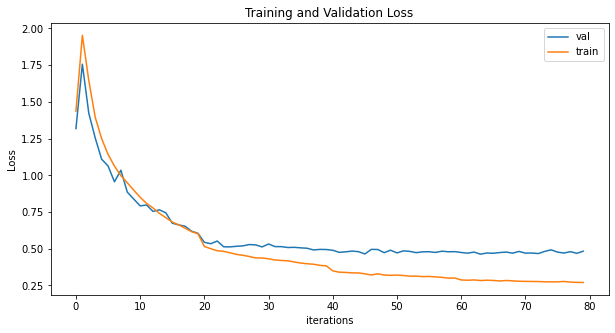

In [40]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_costs,label="val")
plt.plot(train_costs,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

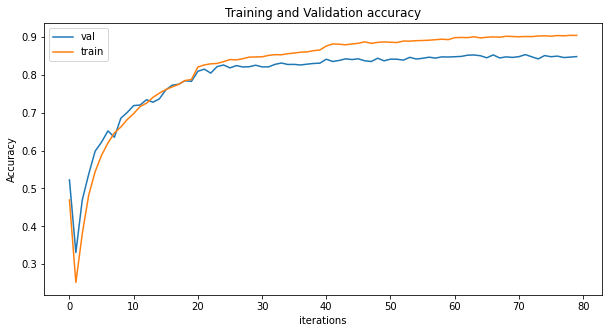

In [41]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation accuracy")
plt.plot(val_acc,label="val")
plt.plot(train_acc,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

##Testing the model

In [42]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 83.8 %
